Loading the data

In [ ]:
from google.colab import drive, files
import pandas as pd

uploaded = files.upload() #upload the data

df= pd.read_parquet("Processed_dataset.parquet")


Saving Processed_dataset.parquet to Processed_dataset.parquet


In [ ]:
!pip install pyarrow
!pip install fastparquet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.1 MB/s eta 0:00:00


Analyzing Normalized Feature Usage in Bot and Human Accounts

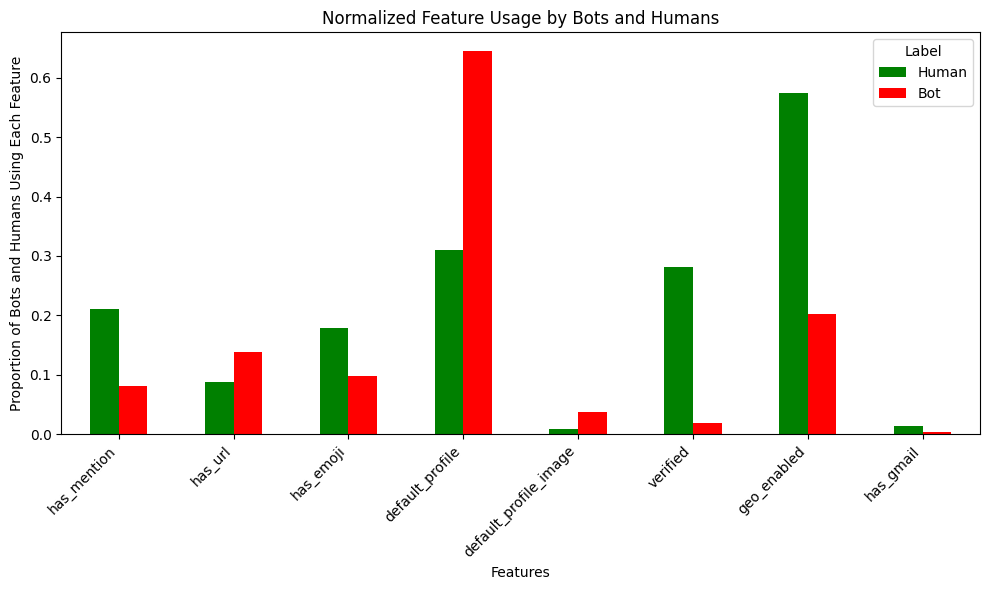

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the parquet file
file_path = 'Processed_dataset.parquet'  # Replace with the actual file path
df = pd.read_parquet(file_path)

# Select only the specified features
selected_features = ['has_mention', 'has_url', 'has_emoji', 'default_profile', 'default_profile_image', 'verified', 'geo_enabled', 'has_gmail']

# Count the total number of bots (label = 1) and humans (label = 0)
total_counts = df['label'].value_counts()

# Separate counts for bots and humans
num_bots = total_counts.get(1, 0)  # Get the count of bots (label = 1), default to 0 if not present
num_humans = total_counts.get(0, 0)  # Get the count of humans (label = 0), default to 0 if not present

# Count the number of bots (label = 1) and humans (label = 0) for each selected feature
result = df.groupby('label')[selected_features].sum()

# Ensure the result DataFrame is using a floating-point dtype
result = result.astype(float)

# Normalize the counts by the total number of bots and humans
result.loc[1] = result.loc[1] / num_bots  # Normalize bot counts
result.loc[0] = result.loc[0] / num_humans  # Normalize human counts

# Rename the indices for better understanding
result.index = ['Human', 'Bot']

# Plot the data with specified colors
result.T.plot(kind='bar', figsize=(10, 6), color=['green', 'red'])
plt.title('Normalized Feature Usage by Bots and Humans')
plt.xlabel('Features')
plt.ylabel('Proportion of Bots and Humans Using Each Feature')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Label')
plt.tight_layout()

# Save the figure
plt.savefig('normalized_feature_usage_by_bots_and_humans.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


Custom RWKV-Based Model for Multi-Modal Classification Integrating Text and Numerical Features

In [ ]:
import torch.nn as nn
import torch
from transformers import AutoModel, AutoTokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the RWKV model
model = AutoModel.from_pretrained("RWKV/rwkv-4-169m-pile")
tokenizer = AutoTokenizer.from_pretrained("RWKV/rwkv-4-169m-pile")

# Add special tokens and adjust embeddings
special_tokens_dict = {'pad_token': '[PAD]', 'cls_token': '[CLS]', 'sep_token': '[SEP]'}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

class ClassificationHead(nn.Module):
    def __init__(self, hidden_size, num_labels):
        super(ClassificationHead, self).__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.out_proj = nn.Linear(hidden_size, num_labels)

    def forward(self, x):
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class RWKVForClassification(nn.Module):
    def __init__(self, model, num_labels, num_features):
        super(RWKVForClassification, self).__init__()
        self.model = model

        # Linear layer for numerical features, transforms their dimensions to the size of the hidden state for later concatenation
        self.feature_layer = nn.Linear(num_features, self.model.config.hidden_size)

        # Classification head
        self.classifier = ClassificationHead(self.model.config.hidden_size * 2, num_labels) #a linear layer that takes in the hidden state as well as the concatenated features, and outputs a probability.

    def forward(self, input_ids, attention_mask=None, features=None):
        # Forward pass through the RWKV model for text inputs
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :].clone()  # Make a copy to avoid in-place operation

        # Forward pass for numerical features
        feature_output = self.feature_layer(features)

        # Concatenate the outputs from the text model and numerical features
        combined_output = torch.cat((cls_output, feature_output), dim=1)

        # Pass through the classification head
        logits = self.classifier(combined_output)
        return logits

# Define number of labels for your classification task
num_labels = len(df['label'].unique())  # Replace with your actual number of classes
num_features = df.drop(columns=['label', 'description', 'location']).shape[1]

classification_model = RWKVForClassification(model, num_labels, num_features)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Custom PyTorch Dataset for Multi-Modal Data: Integrating Textual and Numerical Features

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe

        # Convert all boolean columns to integers and handle non-numeric columns
        for column in self.dataframe.columns:
            if self.dataframe[column].dtype == 'bool':
                self.dataframe[column] = self.dataframe[column].astype(int)
            elif self.dataframe[column].dtype == 'object' and column not in ['description', 'location']:
                # Convert non-text categorical columns to numerical using label encoding
                self.dataframe[column] = self.dataframe[column].astype('category').cat.codes

        # Extract features, excluding the text columns and the label column
        self.features = dataframe.drop(columns=['label', 'description', 'location']).values
        self.label = dataframe['label'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Process the 'description' field
        description = str(self.dataframe.iloc[idx]['description'])
        description_encoding = self.tokenizer.encode_plus(
            description,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Process the 'location' field
        location = str(self.dataframe.iloc[idx]['location'])
        location_encoding = self.tokenizer.encode_plus(
            location,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Combine both textual features' input_ids and attention_masks
        input_ids = torch.cat([description_encoding['input_ids'], location_encoding['input_ids']], dim=1).flatten()
        attention_mask = torch.cat([description_encoding['attention_mask'], location_encoding['attention_mask']], dim=1).flatten()

        # Process the numerical/boolean features
        x_features = torch.tensor(self.features[idx], dtype=torch.float32)

        # Get the label
        y = torch.tensor(self.label[idx], dtype=torch.float32)



        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'features': x_features,
            'label': y
        }


Calculating Zero-One Loss for Model Evaluation on Validation Data

In [ ]:
from sklearn.metrics import accuracy_score

# Function to calculate Zero-One Loss for the validation set
def calculate_zero_one_loss(dataloader, model, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Zero-One Loss (1 - accuracy)
    zero_one_loss = 1 - accuracy_score(all_labels, all_preds)
    return zero_one_loss


Data Preparation and Loader Setup for Training, Validation, and Testing Splits

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import train_test_split
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
import os
from torch.utils.data import Subset

# Step 1: Split the DataFrame into training (80%) and temp (20%) sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 2: Split the temp set into validation (10%) and test (10%) sets
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Step 3: Create the CustomDataset instances
train_dataset = CustomDataset(train_df, tokenizer, 128)
val_dataset = CustomDataset(val_df, tokenizer, 128)
test_dataset = CustomDataset(test_df, tokenizer, 128)

# Step 4: Create the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Training and Evaluating a Classification Model, Cross Entropy and Zero-One Loss Analysis




In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import train_test_split
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
import os
from torch.utils.data import Subset
from google.colab import drive


# Define the device: use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
classification_model = classification_model.to(device)

# Define optimizer, scheduler, and loss function
criterion = nn.CrossEntropyLoss().to(device)

# Function to calculate Cross Entropy Loss for the validation set
def calculate_cross_entropy_loss(dataloader, model, device, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
            loss = criterion(outputs, labels.long())  # Use long for Cross Entropy loss
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

# Training and evaluation loop with a fixed learning rate per run
def train_model_fixed_lr(model, train_dataloader, val_dataloader, device, initial_lr, epochs):
    zero_one_losses = []
    ce_losses = []

    optimizer = AdamW(model.parameters(), lr=initial_lr, correct_bias=False)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
            loss = criterion(outputs, labels.long())  # Use long for Cross Entropy loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f"Epoch {epoch + 6}, Learning Rate: {initial_lr:.5f}, Training Loss: {avg_train_loss:.4f}")

        # Calculate Zero-One Loss and Cross Entropy Loss on the validation set
        val_zero_one_loss = calculate_zero_one_loss(val_dataloader, model, device)
        val_ce_loss = calculate_cross_entropy_loss(val_dataloader, model, device, criterion)

        zero_one_losses.append(val_zero_one_loss)
        ce_losses.append(val_ce_loss)

        print(f"Zero-One Loss: {val_zero_one_loss:.4f}, Cross Entropy Loss: {val_ce_loss:.4f}")

        # Save the model checkpoint
        checkpoint_path = f'model_lr_{initial_lr}_epoch_{epoch + 6}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Model saved to {checkpoint_path}")
        # To download files
        files.download(checkpoint_path)

    return zero_one_losses, ce_losses

# List of initial learning rates to try
#learning_rates = [1.5e-5, 2e-5, 2.5e-5]
learning_rates = [2e-5]

# Storage for results
all_zero_one_losses = {}
all_ce_losses = {}

# Train the model with different initial learning rates
for lr in learning_rates:
    print(f"\nTraining with initial learning rate: {lr}\n")

    # Reset the model to its initial state before each training run
    model = classification_model  # Re-initialize your model if needed
    model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)  # Reset model parameters if possible

    zero_one_losses, ce_losses = train_model_fixed_lr(model, train_dataloader, val_dataloader, device, lr, epochs=5)
    all_zero_one_losses[lr] = zero_one_losses
    all_ce_losses[lr] = ce_losses









Training with initial learning rate: 2e-05



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 6, Learning Rate: 0.00002, Training Loss: 2177.1608
Zero-One Loss: 0.1901, Cross Entropy Loss: 2559.6452
Model saved to model_lr_2e-05_epoch_6.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 7, Learning Rate: 0.00002, Training Loss: 1418.9170
Zero-One Loss: 0.2183, Cross Entropy Loss: 678.4954
Model saved to model_lr_2e-05_epoch_7.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 8, Learning Rate: 0.00002, Training Loss: 982.1462
Zero-One Loss: 0.1836, Cross Entropy Loss: 786.2744
Model saved to model_lr_2e-05_epoch_8.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 9, Learning Rate: 0.00002, Training Loss: 838.1009
Epoch 9, Learning Rate: 0.00002, Training Loss: 838.1009
Zero-One Loss: 0.1826, Cross Entropy Loss: 454.7462
Zero-One Loss: 0.1826, Cross Entropy Loss: 454.7462
Model saved to model_lr_2e-05_epoch_9.pth
Model saved to model_lr_2e-05_epoch_9.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 10, Learning Rate: 0.00002, Training Loss: 650.4481
Epoch 10, Learning Rate: 0.00002, Training Loss: 650.4481
Zero-One Loss: 0.1785, Cross Entropy Loss: 565.1024
Zero-One Loss: 0.1785, Cross Entropy Loss: 565.1024
Model saved to model_lr_2e-05_epoch_10.pth
Model saved to model_lr_2e-05_epoch_10.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Training with initial learning rate: 2e-05

Epoch 11, Learning Rate: 0.00002, Training Loss: 2505.0867
Zero-One Loss: 0.2047, Cross Entropy Loss: 1997.7912
Model saved to model_lr_2e-05_epoch_11.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 12, Learning Rate: 0.00002, Training Loss: 918.2015
Zero-One Loss: 0.1809, Cross Entropy Loss: 1100.9224
Model saved to model_lr_2e-05_epoch_12.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Evaluating and Visualizing Zero-One Loss Across Different Learning Rates and Epochs in a Classification Model

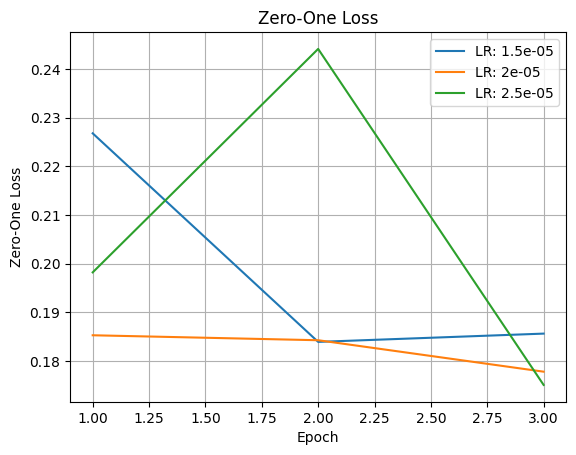

In [18]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Define the learning rates and epochs you have
learning_rates = ['1.5e-05', '2e-05', '2.5e-05']


epochs = [1, 2, 3]

# Initialize a dictionary to store the Zero-One Loss for each learning rate
zero_one_losses = {lr: [] for lr in learning_rates}

def evaluate_zero_one_loss(model, dataloader, device):
    """
    Evaluate Zero-One Loss on a dataset.

    Parameters:
    - model: The model to evaluate.
    - dataloader: DataLoader for the dataset (e.g., validation or test set).
    - device: The device (CPU or GPU) to run the model on.

    Returns:
    - Zero-One Loss (1 - accuracy) for the given dataset.
    """
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            # Move inputs to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)
            labels = batch['label'].to(device)

            # Forward pass: get predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
            preds = torch.argmax(outputs, dim=1)

            # Store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Zero-One Loss (1 - accuracy)
    zero_one_loss = 1 - accuracy_score(all_labels, all_preds)
    return zero_one_loss

# Evaluate and store zero-one losses for each learning rate and epoch
for lr in learning_rates:
    for epoch in epochs:
        model_path = f'model_lr_{lr}_epoch_{epoch}.pth'



        #classification_model.load_state_dict(torch.load('/content/model_epoch_2.pth'))


        # Load the model state dict
        classification_model.load_state_dict(torch.load(model_path))

        # Define the device: use GPU if available, otherwise use CPU
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Move model to device
        classification_model = classification_model.to(device)

        # Evaluate the zero-one loss
        loss = evaluate_zero_one_loss(classification_model, val_dataloader, device)
        zero_one_losses[lr].append(loss)

# Plotting the results
for lr, losses in zero_one_losses.items():
    plt.plot(range(1, len(losses) + 1), losses, label=f'LR: {lr}')

plt.xlabel('Epoch')
plt.ylabel('Zero-One Loss')
plt.title('Zero-One Loss per Epoch for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.savefig('zero_one_loss_plot.png')  # Save the plot as a PNG file
plt.show()


Evaluating and Visualizing Zero-One Loss Across Epochs for the Selected Learning Rate: 2e-05





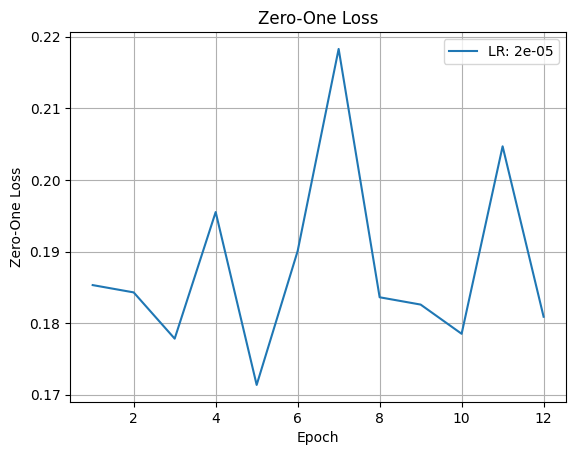

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Define the learning rates and epochs you have

learning_rates = [ '2e-05']

epochs = [1, 2, 3, 4, 5, 6, 7, 8 ,9, 10, 11, 12]

# Initialize a dictionary to store the Zero-One Loss for each learning rate
zero_one_losses = {lr: [] for lr in learning_rates}

def evaluate_zero_one_loss(model, dataloader, device):
    """
    Evaluate Zero-One Loss on a dataset.

    Parameters:
    - model: The model to evaluate.
    - dataloader: DataLoader for the dataset (e.g., validation or test set).
    - device: The device (CPU or GPU) to run the model on.

    Returns:
    - Zero-One Loss (1 - accuracy) for the given dataset.
    """
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            # Move inputs to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)
            labels = batch['label'].to(device)

            # Forward pass: get predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
            preds = torch.argmax(outputs, dim=1)

            # Store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Zero-One Loss (1 - accuracy)
    zero_one_loss = 1 - accuracy_score(all_labels, all_preds)
    return zero_one_loss

# Evaluate and store zero-one losses for each learning rate and epoch
for lr in learning_rates:
    for epoch in epochs:
        model_path = f'model_lr_{lr}_epoch_{epoch}.pth'



        #classification_model.load_state_dict(torch.load('/content/model_epoch_2.pth'))


        # Load the model state dict
        classification_model.load_state_dict(torch.load(model_path))

        # Define the device: use GPU if available, otherwise use CPU
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Move model to device
        classification_model = classification_model.to(device)

        # Evaluate the zero-one loss
        loss = evaluate_zero_one_loss(classification_model, val_dataloader, device)
        zero_one_losses[lr].append(loss)

# Plotting the results
for lr, losses in zero_one_losses.items():
    plt.plot(range(1, len(losses) + 1), losses, label=f'LR: {lr}')

plt.xlabel('Epoch')
plt.ylabel('Zero-One Loss')
plt.title('Zero-One Loss')
plt.legend()
plt.grid(True)
plt.savefig('zero_one_loss_plot.png')  # Save the plot as a PNG file
plt.show()


Evaluating and Visualizing Cross Entropy Loss Across Epochs for Multiple Learning Rates

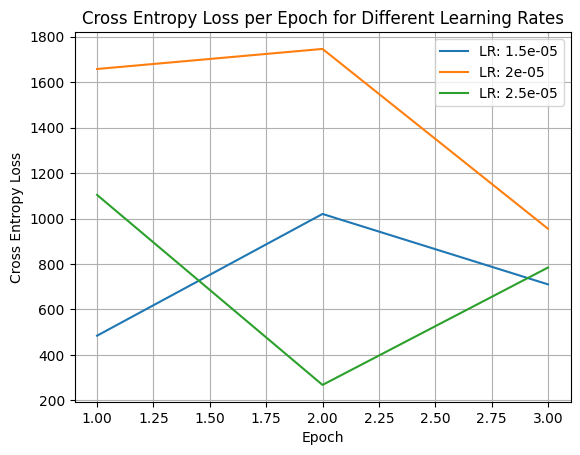

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define the learning rates and epochs you have
learning_rates = ['1.5e-05', '2e-05', '2.5e-05']
epochs = [1, 2, 3]

# Initialize a dictionary to store the Cross Entropy Loss for each learning rate
cross_entropy_losses = {lr: [] for lr in learning_rates}

def evaluate_cross_entropy_loss(model, dataloader, device):
    """
    Evaluate Cross Entropy Loss on a dataset.

    Parameters:
    - model: The model to evaluate.
    - dataloader: DataLoader for the dataset (e.g., validation or test set).
    - device: The device (CPU or GPU) to run the model on.

    Returns:
    - Average Cross Entropy Loss for the given dataset.
    """
    model.eval()  # Set the model to evaluation mode
    criterion = nn.CrossEntropyLoss()  # Define the Cross Entropy Loss function
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            # Move inputs to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)
            labels = batch['label'].to(device).long()

            # Forward pass: get predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, features=features)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

    # Return the average loss over all samples
    avg_loss = total_loss / total_samples
    return avg_loss

# Evaluate and store Cross Entropy losses for each learning rate and epoch
for lr in learning_rates:
    for epoch in epochs:
        model_path = f'model_lr_{lr}_epoch_{epoch}.pth'

        # Load the model state dict
        classification_model.load_state_dict(torch.load(model_path))

        # Define the device: use GPU if available, otherwise use CPU
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Move model to device
        classification_model = classification_model.to(device)

        # Evaluate the cross entropy loss
        loss = evaluate_cross_entropy_loss(classification_model, val_dataloader, device)
        cross_entropy_losses[lr].append(loss)

# Plotting the results
for lr, losses in cross_entropy_losses.items():
    plt.plot(range(1, len(losses) + 1), losses, label=f'LR: {lr}')

plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Cross Entropy Loss per Epoch for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.savefig('cross_entropy_loss_plot.png')  # Save the plot as a PNG file
plt.show()


Tracking Cross Entropy Loss Across Epochs for the Selected Learning Rate: 2e-05

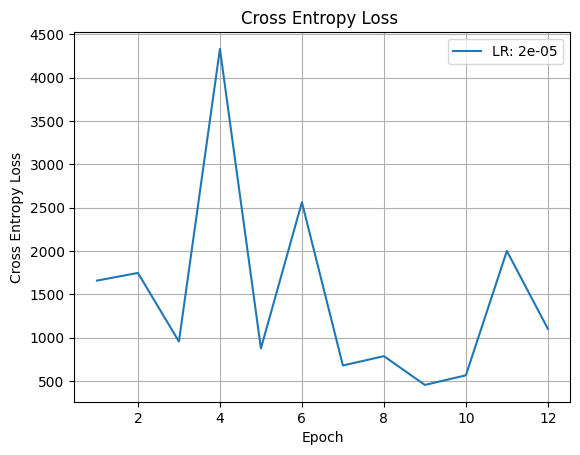

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define the learning rates and epochs you have
learning_rates = [ '2e-05']
epochs = [1, 2, 3, 4, 5,6 ,7, 8, 9, 10, 11, 12]

# Initialize a dictionary to store the Cross Entropy Loss for each learning rate
cross_entropy_losses = {lr: [] for lr in learning_rates}

def evaluate_cross_entropy_loss(model, dataloader, device):
    """
    Evaluate Cross Entropy Loss on a dataset.

    Parameters:
    - model: The model to evaluate.
    - dataloader: DataLoader for the dataset (e.g., validation or test set).
    - device: The device (CPU or GPU) to run the model on.

    Returns:
    - Average Cross Entropy Loss for the given dataset.
    """
    model.eval()  # Set the model to evaluation mode
    criterion = nn.CrossEntropyLoss()  # Define the Cross Entropy Loss function
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            # Move inputs to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)
            labels = batch['label'].to(device).long()

            # Forward pass: get predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, features=features)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

    # Return the average loss over all samples
    avg_loss = total_loss / total_samples
    return avg_loss

# Evaluate and store Cross Entropy losses for each learning rate and epoch
for lr in learning_rates:
    for epoch in epochs:
        model_path = f'model_lr_{lr}_epoch_{epoch}.pth'

        # Load the model state dict
        classification_model.load_state_dict(torch.load(model_path))

        # Define the device: use GPU if available, otherwise use CPU
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Move model to device
        classification_model = classification_model.to(device)

        # Evaluate the cross entropy loss
        loss = evaluate_cross_entropy_loss(classification_model, val_dataloader, device)
        cross_entropy_losses[lr].append(loss)

# Plotting the results
for lr, losses in cross_entropy_losses.items():
    plt.plot(range(1, len(losses) + 1), losses, label=f'LR: {lr}')

plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Cross Entropy Loss ')
plt.legend()
plt.grid(True)
plt.savefig('cross_entropy_loss_plot.png')  # Save the plot as a PNG file
plt.show()


Loading Best Model Checkpoint (Epoch 5, LR 2e-05) for Accuracy Calculation

In [ ]:
classification_model.load_state_dict(torch.load('model_lr_2e-05_epoch_5.pth'))


<All keys matched successfully>

Evaluating Precision, Recall, and Accuracy on the Test Set Using the Best Model Checkpoint

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def calculate_metrics(dataloader, model, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average='binary')  # Assuming binary classification
    recall = recall_score(all_labels, all_preds, average='binary')
    accuracy = accuracy_score(all_labels, all_preds)

    return precision, recall, accuracy

# Calculate precision, recall, and accuracy on the test set
test_precision, test_recall, test_accuracy = calculate_metrics(test_dataloader, classification_model, device)
print(f"Test Precision for learning rate {lr}: {test_precision:.4f}")
print(f"Test Recall for learning rate {lr}: {test_recall:.4f}")
print(f"Test Accuracy for learning rate {lr}: {test_accuracy:.4f}")


Test Precision for learning rate 2e-05: 0.7272
Test Recall for learning rate 2e-05: 0.7196
Test Accuracy for learning rate 2e-05: 0.8198
